# Gradient Descent

The gradient of a scalar function $f(\theta)$ is its vector derivative $ \nabla_\theta f(\theta) = \left[ \frac {\partial f(\theta)}{\partial \theta_1}, \frac {\partial f(\theta)}{\partial \theta_2}, \dots, \frac {\partial f(\theta)}{\partial \theta_n} \right]$ with respect to some vector $\theta$. The gradient is a vector that points in the direction of maximum increase of the function $f(\theta)$, with magnitude equal to the rate of increase. As an example, the gradient of the electric potential with respect to position is the electric field: $\displaystyle  E = \nabla_r \varphi(r)$.

We can use gradient descent to minimize a cost function, just as we did for [multivariate linear regression](LinearRegression.ipynb). In fact, gradient descent is superior to linear regression in a couple circumstances: 1) when the relationship between $\mathsf X$ and $\mathsf Y$ is not linear, and 2) when we wish to minimize a cost function other than least squares. Linear regression will fail to minimize the cost function in both circumstances. There may also be performance advantages when the matrix $\mathsf X$ gets very large.

Given a cost function $J(\theta)$ with gradient $\nabla_\theta J(\theta)$ we can construct an algorithm to descend the gradient to find a (possibly local) minimum of the cost function $J(\theta)$. We pick a random starting point in parameter space, $\theta_0$, ideally not too far from the optimum. We then take a step in the opposite direction to the gradient, proportional to the magnitude of the gradient but scaled by a learning factor $\alpha$. We repeat this procedure as long as required to achive an acceptable good fit to the minimum. In vector form general form of equation at step $t$ is

$$\;\;\;\;\;\;\;\; \mathsf \theta \gets \mathsf \theta - \alpha \left( \nabla_{\theta} J(\theta)\right)^T \;\;\;\;\;\;\;\; (1)$$

There are several questions we need to answer yet:

1) How do we determine $\nabla_\theta J(\theta)$?

2) How do we determine the learning factor $\alpha$?

3) How long must we expect to iterate, or what is the maximum $t$ we should expect?

Consider the squared error cost function, defined in precísely the same way as we did for [multivariate linear regression](LinearRegression.ipynb):

$$ \;\;\;\;\;\;\;\; J(\theta) = \mathsf \epsilon^T \mathsf \epsilon = \left(\mathsf Y - \mathsf X \mathsf \theta \right)^T \left( \mathsf Y  - \mathsf X \mathsf \theta \right)  = \left( \mathsf {Y^T} - \mathsf {\theta^T} \mathsf {X^T} \right) \left(\mathsf Y - \mathsf X \mathsf \theta \right) \;\;\;\;\;\;\;\; (2)$$

Then the gradient of the cost function with respect to $\theta$ is a (row) vector given by

$$ \;\;\;\;\;\;\;\; \nabla_\theta J(\theta) =  - 2  \left(\mathsf Y^T \mathsf X - \mathsf \theta^T \mathsf X^T \mathsf X \right) \;\;\;\;\;\;\;\; (3)$$

Substitute Eq(3) into Eq(1) and we have a useful means of executing gradient descent:

$$\theta \gets \theta + 2 \alpha \left( \mathsf Y^T \mathsf X - \theta^T \mathsf X^T \mathsf X \right)^T$$

$$\;\;\;\;\;\;\;\;\;\;\;\; \theta \gets \theta + 2 \alpha \left( \mathsf X^T \mathsf Y - \mathsf X^T \mathsf X \theta \right) \;\;\;\;\;\;\;\; (4)$$

Now we need to choose a value for $\alpha$. It turns out there is no universally correct way to do this. It depends on the situation. However, $\alpha$ should be considerably smaller that $1$ for a squared error cost function. Otherwise if the initial guess at $\theta$ is sufficiently far from the minimum then the gradient descent can overshoot and run away towards $\infty$. 

The best way to optimize $\alpha$ is to try out various values, but for that we need data. Let's load some now and give it a try.

In [1]:
data = readdlm("MLdata.txt")
# NB: if you run this notebook yourself you will get different results. I was not able
# to upload the full data set to GitHub. Sorry.

X = data[:,2:end]
Y = data[:,1]
data = 0
println("OK")

OK


Now we perform a QR decomposition on $\mathsf X$ to eliminate dependent columns and orthoganalize the features.

In [2]:
@time Q, R = qr(X)
n = size(R)[1]
Rtrace = sort!([R[i,i] for i=1:n], by=abs, rev=true)
X = 0

Q¹ = Array{Float64, 2}(size(Q)[1], 0)
for i = 1:size(R)[2]
    if abs(R[i,i]) > 1e0
       Q¹ = hcat(Q¹, Q[:,i])
    end
end

Q = Q¹
R = 0

 40.064969 seconds (172.28 k allocations: 981.944 MB, 6.57% gc time)


0

In [5]:
MSE(X, Y, θ) = mean((Y .- X*θ).^2)

MSE (generic function with 1 method)

Making use of the orthonormal matrix Q we find

$$\;\;\;\;\;\;\;\; \theta \gets \theta + 2 \alpha \left( \mathsf Q^T \mathsf Y - \theta \right) \;\;\;\;\;\;\;\; (5)$$

We split the data into training and test sets, and initialize $\theta$ to some random values.

In [ ]:
θ⁰ = randn(size(Q)[2])

N = size(Y)[1]
examples = shuffle(1:N)
cut = 9*N÷10

train = examples[1:cut]
test = examples[cut+1:end]
Qtr, Qt = Q[train,:], Q[test,:]
Ytr, Yt = Y[train], Y[test]

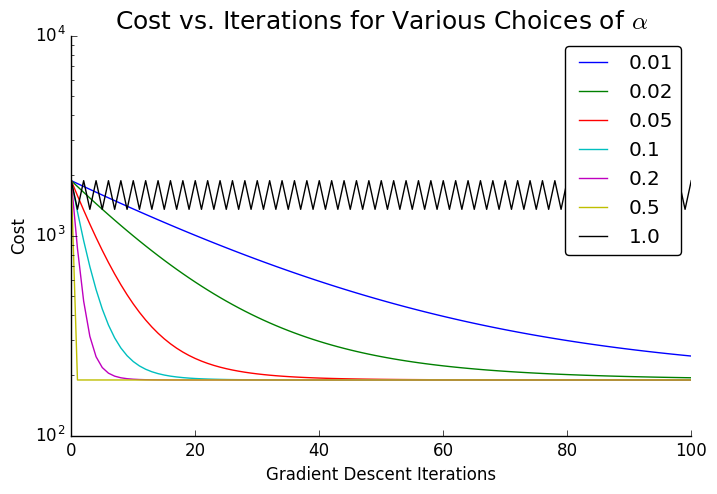

In [54]:
using PyPlot
fig = figure(figsize=(8,5))
ax = axes()
tmax = 100
for α in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    θ = θ⁰
    MSEs = []
    push!(MSEs, mean((Yt - Qt*θ).^2))
    for t = 1:tmax
        θ = θ  + 2*α*(transpose(Qtr)*Ytr - θ)
        push!(MSEs, mean((Yt - Qt*θ) .^2))
    end
    plot(0:tmax, MSEs, label="$α")
end

ax[:set_yscale]("log")
xlabel("Gradient Descent Iterations")
ylabel("Cost")
title(L"Cost vs. Iterations for Various Choices of $\alpha$", fontsize=18.0)

legend(loc="best",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

Notice that the cost when $\alpha=1$ jumps back and forth between two high values and never improves. This is because for a hyperparabola (like the squared error cost function) has a gradient at point $\theta$ equal in magnitude to $2 \theta$. That means that a learning rate of $\alpha=1$ takes the cost function back and forth between $\pm \theta$, and hence it stays nearly constant in magnitude. But why only nearly? Recall that we use the training data to determine $\theta$, but then use that $\theta$ to make predictions with the test data and thereby calculate values of $J$. Thus whereas $\pm \theta$ yield the same value of $J$ for the training data, $+\theta$ yields a slightly different value than does $-\theta$ on the test data.

For nearly the same reason, when $\alpha=0.5$ the cost function immediately drops to its minimum and stays there. This is naturally the same value as determined by linear regression. But let's prove that.

$$\theta \gets \theta + 2 \alpha \left( \mathsf Q^T \mathsf Y - \theta \right) $$

If $\alpha = \frac 1 2$


$$\theta \gets \theta + 2 \left( \frac 1 2 \right) \left( \mathsf Q^T \mathsf Y - \theta \right) $$

$$\theta \gets \theta + \mathsf Q^T \mathsf Y - \theta  $$

$$\theta \gets \mathsf Q^T \mathsf Y $$

which is nothing less than linear regression.

Getting back to the question of how to choose $\alpha$, and how many iterations are required, we can answer conclusively for the case of a squared error cost function. Choose $\alpha = \frac 1 2$ and anticipate a single iteration.

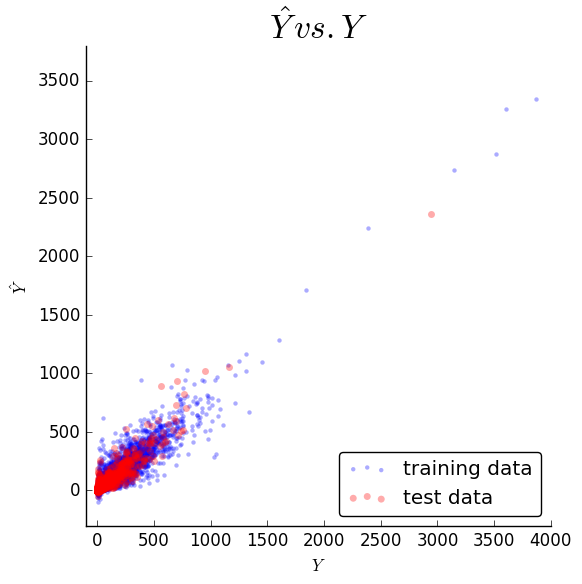

In [44]:
using PyPlot

α = 0.5
θ = θ⁰  + transpose(2*α*(transpose(Ytr)*Qtr - transpose(θ⁰)))

fig = figure(figsize=(6,6))
ax = axes()
scatter(Ytr, (Qtr*θ), c="blue", s=10, linewidth=0, alpha=0.33, label="training data")
scatter(Yt, (Qt*θ), c="red", s=25, linewidth=0, alpha=0.33, label="test data")
ax[:set_xlim]([-100,4000])
ax[:set_ylim]([-300;3800])

xlabel(L"$Y$")
ylabel(L"$\hat Y$")
title(L"$\hat Y vs. Y$", fontsize=24.0)

legend(loc="lower right",fancybox="true")

ax[:spines]["top"][:set_color]("none")
ax[:spines]["right"][:set_color]("none")
ax[:xaxis][:set_ticks_position]("bottom")
ax[:yaxis][:set_ticks_position]("left")

# Conjugate Gradient

The gradient of the squared error cost function at the point $\theta_0$ is given by

$$ \nabla_\theta J(\theta_0) =  - 2  \left(\mathsf Y^T \mathsf Q - \mathsf \theta_0^T  \right)$$

Suppose we descend the gradient as with gradient descent, but rather than preselecting an arbitrary $\alpha$ we wish to find the optimal step size to descend as far and as fast as possible. How might we do this? Well, a good idea is to step precisely so far as to minimize the cost function $J$ along the line of descent. The point along the line of descent at which the cost function is minimized is characterized by a gradient that is perpendicuar to the line of descent. In other words, we wish to find the point $\displaystyle \theta_1 = \theta_0 - \alpha \left( \nabla_\theta J(\theta_0) \right)^T$ at which $\nabla_\theta J(\theta_1)$ is perpendicular to $\nabla_\theta J(\theta_0)$. The gradient at that unknown point is 

$$ \nabla_\theta J(\theta_1) =  - 2  \left(\mathsf Y^T \mathsf Q - \mathsf \theta_1^T  \right)$$

$$ \nabla_\theta J(\theta_1) =  - 2  \left(\mathsf Y^T \mathsf Q - \left( \theta_0 - \alpha \left( \nabla_\theta J(\theta_0) \right)^T \right)^T  \right)$$

$$ \nabla_\theta J(\theta_1) =  - 2  \left(\mathsf Y^T \mathsf Q - \left( \theta_0 + 2 \alpha \left(\mathsf Y^T \mathsf Q - \mathsf \theta_0^T \right)^T \right)^T  \right)$$

$$ \nabla_\theta J(\theta_1) =  - 2  \left(\mathsf Y^T \mathsf Q - \theta_0^T - 2 \alpha \mathsf Y^T \mathsf Q + 2 \alpha  \mathsf \theta_0^T  \right)$$

$$ \nabla_\theta J(\theta_1) =  - 2  \left( 1 - 2 \alpha \right) \left( \mathsf Y^T \mathsf Q - \theta_0^T   \right)$$

Now we seek the value of $\alpha$ for which $\left( \nabla_\theta J(\theta_1) \right)^T \nabla_\theta J(\theta_0) = 0$. This happens when

$$ 4 \left( 1 - 2 \alpha \right) \left( \mathsf Y^T \mathsf Q - \theta_0^T   \right)^T  \left(\mathsf Y^T \mathsf Q - \mathsf \theta_0^T  \right) = 0 $$

or when $\alpha = \frac 1 2$. This results in linear regression again. Perhaps things would be more interesting if we were to consider some cost function other than squared error.